# Modellen met tranferlearning

## Imports & setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

# importeren van zelf geschreven modules
from Callbacks.RealTimePlotCallback import RealTimePlotCallback
from dataset_module import dataset_creation

In [2]:
while os.getcwd() != "C:\\My Projects\\Opdracht-schilders":
    os.chdir('..')

os.chdir("4. Eigen Modellen/4.2 CNN met transfer learning")
os.getcwd()

'C:\\My Projects\\Opdracht-schilders\\4. Eigen Modellen\\4.2 CNN met transfer learning'

In [3]:
classes = os.listdir("../../datasets/paintings")

In [4]:
(train_data, train_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/train/")
(val_data, val_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/validation")
(test_data, test_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/test")

..\..\datasets\dataset\train\Picasso\150.jpg --> FAILED
..\..\datasets\dataset\test\Picasso\1502.jpg --> FAILED


## VGG16

Ik zal beginnen met het VGG16 pretrained model. Ik zal gebruik maken van een **Hold-out validation** (geen k-fold validation, omdat de dataset groot genoeg is) en zal me baseren op de **accuracy & loss metrieken**.

In [5]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False


input_layer = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(input_layer)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

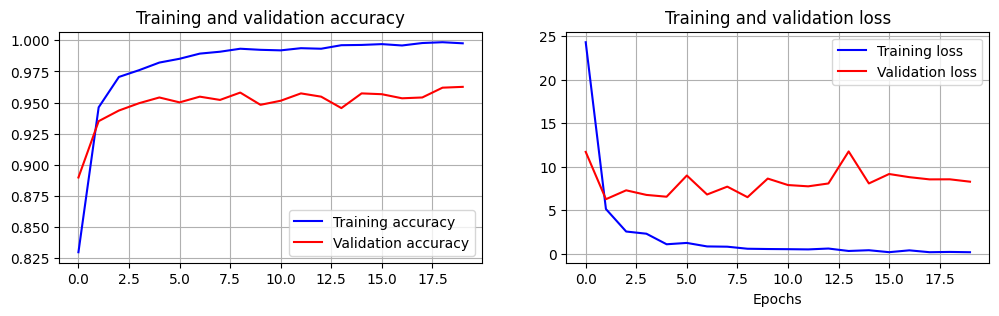

training loss: 0.15409348905086517
validation loss: 8.268531799316406
training accuracy: 0.9976029396057129
validation accuracy: 0.9626229405403137

epochs: 20

144/144 [==============================] - 20s 138ms/step - loss: 0.1541 - accuracy: 0.9976 - val_loss: 8.2685 - val_accuracy: 0.9626


In [6]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
         filepath="VGG16_base.keras",  # file waarin model wordt opgeslagen
         save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
         monitor="val_loss"),
     keras.callbacks.EarlyStopping(
         monitor="val_accuracy",
         patience=10),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=20,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

Na 1 epoch zien we op de loss grafiek dat er overfitting plaatsvindt. Toch blijft de accuracy stijgen tot ongeveer de 4 epoch en stagneert daar.

48/48 [==============================] - 7s 141ms/step


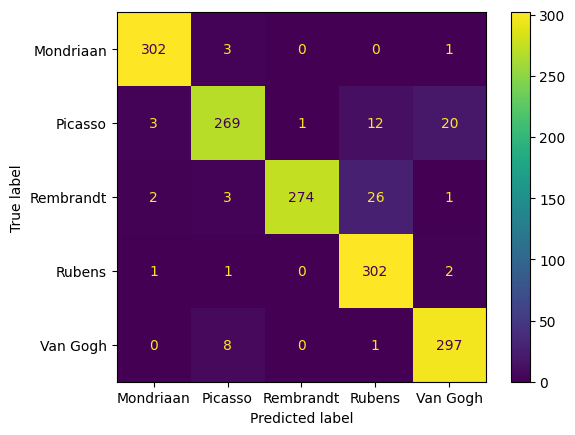

In [9]:
model = keras.models.load_model("VGG16_base.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Op de confusion matrix zien we dat het model Rembrandt soms verward met Rubens en Picasso soms verward met Van Gogh.

In [10]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 76ms/step - loss: 7.1120 - accuracy: 0.9444


[7.111979007720947, 0.944408118724823]

Het model heeft een **accuracy van 94%**, dit is goed. We zien wel dat we een **hoge loss hebben van 7.11**.

Aangezien VGG16 een wat ouder pretrained model is, zal ik vanaf nu verderwerken met Resnet. Onderstaand screenshot komt uit deze [bron](https://ieeexplore.ieee.org/document/9687944) (bron vermelding hieronder) en komt ook tot de conclusie dat ResNet50 beter is dan VGG16 en VGG19.

![ResNet50 vs VGG16 Quote](quote%20ResNet50.JPG)

S. Mascarenhas and M. Agarwal, "A comparison between VGG16, VGG19 and ResNet50 architecture frameworks for Image Classification," 2021 International Conference on Disruptive Technologies for Multi-Disciplinary Research and Applications (CENTCON), 2021, pp. 96-99, doi: 10.1109/CENTCON52345.2021.9687944.

## Resnet

Ik zal nu dat ik VGG16 eens heb uitgeprobeerd, verderwerken met ResNet50.

In [5]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

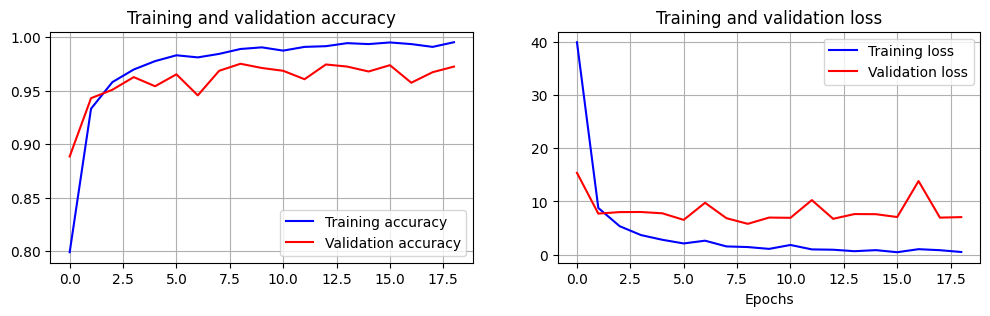

training loss: 0.5022587180137634
validation loss: 7.048577785491943
training accuracy: 0.9952059388160706
validation accuracy: 0.9724590182304382

epochs: 19

144/144 [==============================] - 14s 100ms/step - loss: 0.5023 - accuracy: 0.9952 - val_loss: 7.0486 - val_accuracy: 0.9725


In [7]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_basic.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

We bekomen een hoge loss, maar het model trained wel tot een goede accuracy van rond de 97% (beter dan VGG16). Aangezien de training loss veel lager is dan de validatie loss, kunnen we hier uitgaan van overfitting rond epoch 1 (net zoals bij VGG16).

48/48 [==============================] - 4s 78ms/step


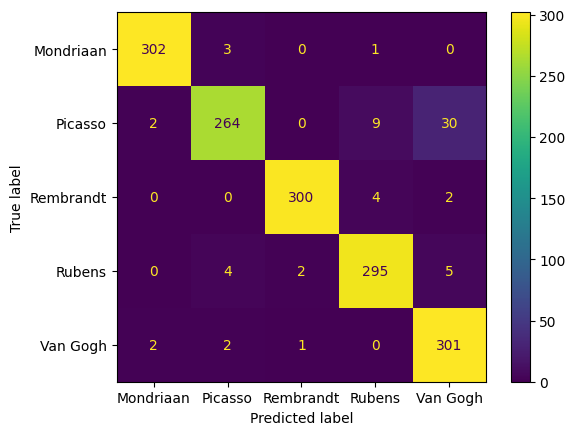

In [9]:
model = keras.models.load_model("ResNet_basic.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

We zien op de confusion matrix dat het model nog steeds Picasso soms verward met Van Gogh. Anders dan dat ziet het er goed uit.

In [10]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 68ms/step - loss: 9.9715 - accuracy: 0.9562


[9.971539497375488, 0.9561805129051208]

Het model behaalt heeft een **accuracy van 96%**, dit is beter dan het VGG16 model. Het heeft wel een hogere **loss** dan die van VGG16, namelijk **9.98**.

## Resnet met data augmentation

Ik volg dezelfde redenering als deze die ik in "4.1 Eigen Convolutioneel Netwerk" heb gesteld over de data augmentation. Daar vertel ik u welke data augmentation layers ik gebruik en waarom. Ik heb nu ook eens met RandomTranslation gewerkt, maar dit gaf geen betere resultaten.

In [5]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.3),
            layers.RandomZoom(0.2),
            # layers.RandomTranslation(0.2, 0.2)
        ]
)

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

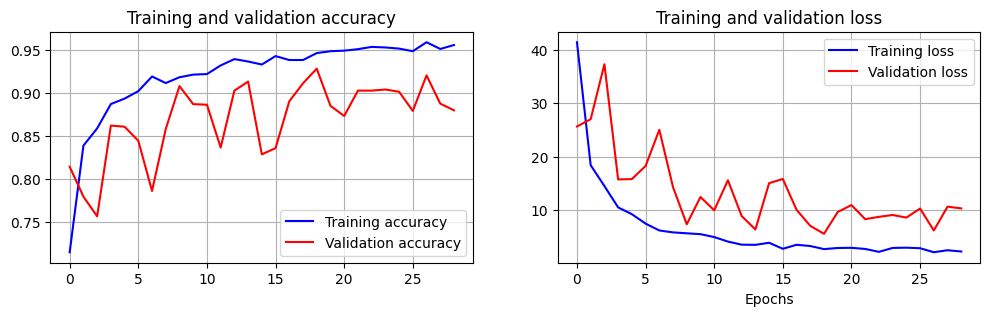

training loss: 2.2327332496643066
validation loss: 10.292306900024414
training accuracy: 0.9559816718101501
validation accuracy: 0.8799999952316284

epochs: 29

144/144 [==============================] - 54s 373ms/step - loss: 2.2327 - accuracy: 0.9560 - val_loss: 10.2923 - val_accuracy: 0.8800


In [6]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

48/48 [==============================] - 5s 73ms/step


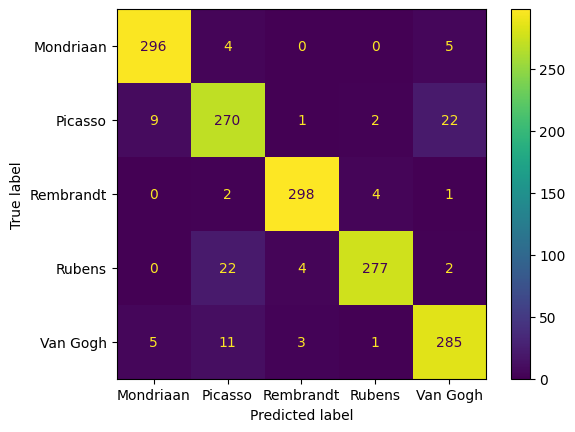

In [11]:
model = keras.models.load_model("ResNet_data_augmentation.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

In [12]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 6s 82ms/step - loss: 4.9391 - accuracy: 0.9357


[4.939082622528076, 0.9356955289840698]

Net zoals bij mijn eigen CNN's zorgt data augmentation ervoor dat mijn accuracy naar beneden gaat. We bekomen een iets lagere **accuracy van 93.6%**, maar we hebben wel een **betere loss van 4.94**.

Momenteel zou ik dit model verkiezen boven het model zonder data augmentation, dit omdat alhoewel de accuracy wat naar beneden gaat, we toch een hele verbetering hebben van de loss.

## ResNet met trainbare convbase

Ik zal nu mijn model laatste 4 lagen van de ConvBase toelaten te hertrainen, hopelijk met als resultaat een beter model.

In [ ]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

In [ ]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_data_augmentation_retrainable_convbase.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

![Traingraph 4 trainable convbase layers](training%20graph%204%20trainable%20conv%20base%20layers.JPG)

Hierboven ziet u de training graph van dit model. Deze was verdwenen, maar heb deze teruggevonden via GitHub (vandaar dat dit als screenshot in deze notebook staat). We bekomen na 5 epochs een model van ongeveer 97%, na epoch 5 stagneert deze. Na epoch 7 begint de validatie loss ook weer te stijgen.

48/48 [==============================] - 4s 64ms/step


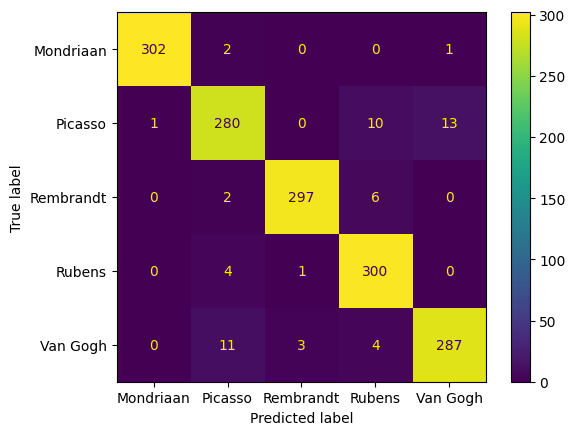

In [11]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Op de confusion matrix zien we dat er nog steeds een kleine verwarring is tussen Picasso met Rubens en Van Gogh. Ook Van Gogh wordt nog een beetje verward met Picasso.

In [6]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 65ms/step - loss: 0.2912 - accuracy: 0.9652


[0.291231244802475, 0.9652230739593506]

We bekomen een **accuracy van 97%** en een **loss van 0.29**. Deze loss is enorm veel verbeterd in vergelijking met de vorige versie van het model.

### 6 trainable lagen

Ik zal nu eens met 6 trainable lagen werken in plaats van 4, misschien verkrijg ik hierdoor een nog beter resultaat.

In [7]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-6]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

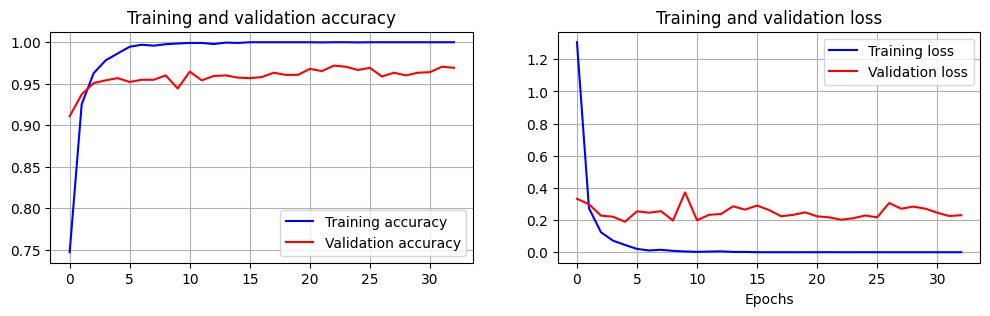

training loss: 2.098265667882515e-06
validation loss: 0.2301434874534607
training accuracy: 1.0
validation accuracy: 0.9691803455352783

epochs: 33

144/144 [==============================] - 15s 105ms/step - loss: 2.0983e-06 - accuracy: 1.0000 - val_loss: 0.2301 - val_accuracy: 0.9692


In [8]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_data_augmentation_retrainable_convbase_6_layers.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

48/48 [==============================] - 8s 81ms/step


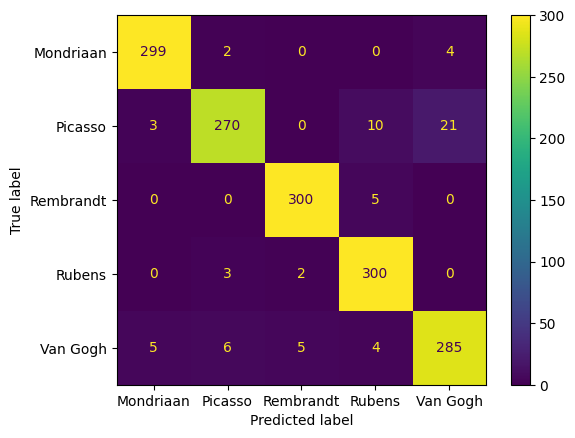

In [9]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_6_layers.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Wederom zien we dat Picasso weer verward wordt met Van Gogh, dit blijkt een patroon te zijn met ResNet.

In [10]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 75ms/step - loss: 0.2186 - accuracy: 0.9541


[0.21864885091781616, 0.9540682435035706]

We zien dat de **accuracy wat gedaald is naar 95%**, maar de **loss is ook verder gedaald naar 0.2186**.


### 3 trainable lagen

Nu zal ik eens proberen met enkel 3 trainable lagen.

In [8]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-3]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

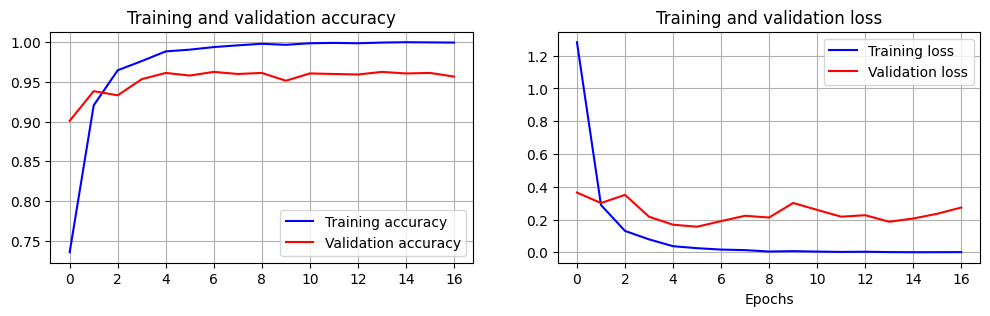

training loss: 0.001089409808628261
validation loss: 0.27316364645957947
training accuracy: 0.9995641708374023
validation accuracy: 0.956721305847168

epochs: 17

144/144 [==============================] - 16s 110ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.2732 - val_accuracy: 0.9567


In [9]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_data_augmentation_retrainable_convbase_3_layers.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

48/48 [==============================] - 5s 81ms/step


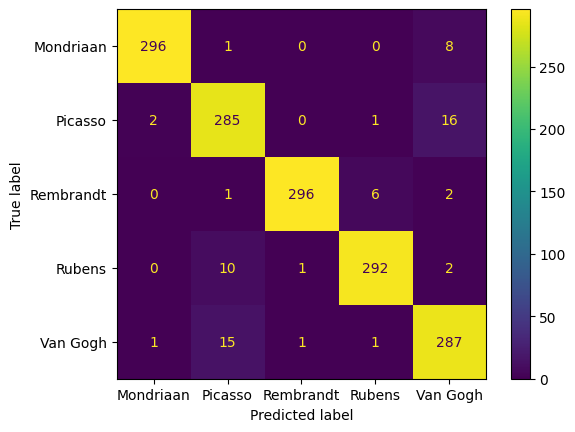

In [10]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_3_layers.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Geen nieuwe bevindingen op de confusion matrix, nog steeds de verwarring tussen dezelfde schilders.

In [12]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_3_layers.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 71ms/step - loss: 0.2314 - accuracy: 0.9554


[0.23141346871852875, 0.9553805589675903]

Ik bekom met 3 trainable convbase lagen een **accuracy van 96%** en een **loss van 0.23**, dit ligt ongeveer gelijk als bij het model met 6 trainable lagen.

We zien dat er niet meteen verbeteringen zijn. 3 trainable lagen loopt gelijk met het model met 6 trainable lagen van de convbase.
Ik zal nu voor de zekerheid nog eens een model met 5 trainable convbase lagen laten trainen, aangezien ik van 4 meteen naar 6 sprong.

### 5 lagen

In [13]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

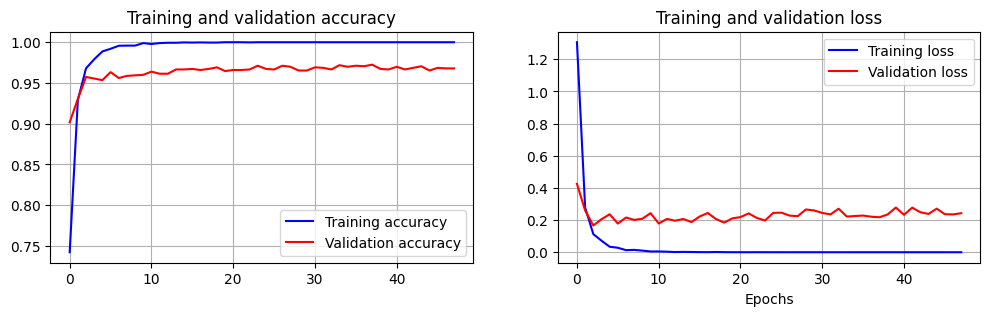

training loss: 4.1563009034462084e-08
validation loss: 0.24275892972946167
training accuracy: 1.0
validation accuracy: 0.9678688645362854

epochs: 48

144/144 [==============================] - 16s 110ms/step - loss: 4.1563e-08 - accuracy: 1.0000 - val_loss: 0.2428 - val_accuracy: 0.9679


In [14]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_data_augmentation_retrainable_convbase_5_layers.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

48/48 [==============================] - 4s 74ms/step


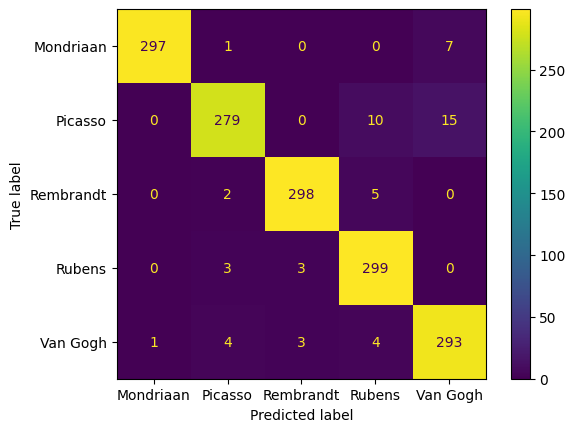

In [15]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_5_layers.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Alhoewel onze accuracy een klein beetje lager is dan het model met de 4 trainable lagen, zien we wel dat er in dit model met 5 lagen minder verwarring is tussen de schilders. Er is wel nog steeds verwarring tussen Picasso met Rubens en Van Gogh.

In [16]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_5_layers.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 72ms/step - loss: 0.3094 - accuracy: 0.9619


[0.30944252014160156, 0.9619422554969788]

Hierbij bekom ik een **accuracy van 96%** en een **loss van 0.31**.

De resultaten liggen ongeveer hetzelfde als bij de 4 trainable lagen. Het model met 4 trainable lagen is wel degelijk het beste model die ik bekwam, dus is dit ook het model die ik kies als mijn finale model.

# Model met 4 lagen (nu met data augmentation)


Ik maakte geen gebruik van data augmentation toen ik mijn trainable convbase model maakte. Ik zal nu dezelfde data augmentation laag gebruik die ik gebruikte in het "ResNet met data augmentation" stuk van deze notebook.

<Figure size 640x480 with 0 Axes>

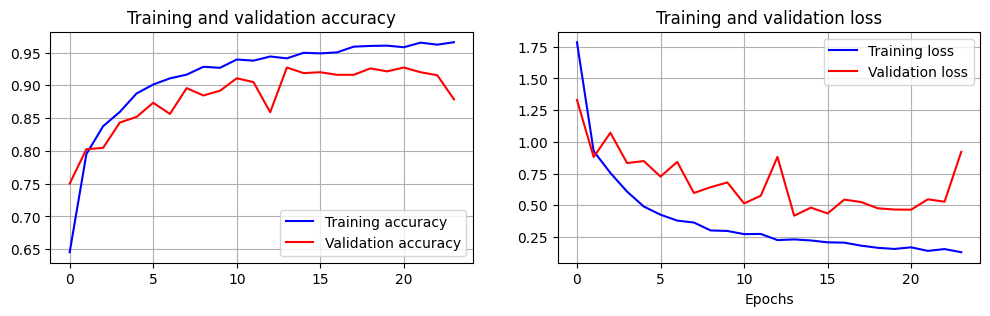

training loss: 0.13056819140911102
validation loss: 0.9221532344818115
training accuracy: 0.9657877683639526
validation accuracy: 0.8786885142326355

epochs: 24

144/144 [==============================] - 54s 377ms/step - loss: 0.1306 - accuracy: 0.9658 - val_loss: 0.9222 - val_accuracy: 0.8787


In [5]:
# Modellen met tranferlearning
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        # layers.RandomTranslation(0.2, 0.2)
    ]
)

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="ResNet_data_augmentation_retrainable_convbase_da.keras",  # file waarin model wordt opgeslagen
        save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
    ),
    RealTimePlotCallback()
]

history = model.fit(
    train_data, train_labels,
    epochs=50,
    validation_data=(val_data, val_labels),
    callbacks=callbacks_list)

Na 24 epochs is het trainen gestopt vanwege de EarlyStopping callback die ik gebruik. Ik denk dat ik er misschien nog een beter model uit kan krijgen wanneer het nog wat langer trained. Hieronder zal ik het model nog wat verder trainen.

<Figure size 640x480 with 0 Axes>

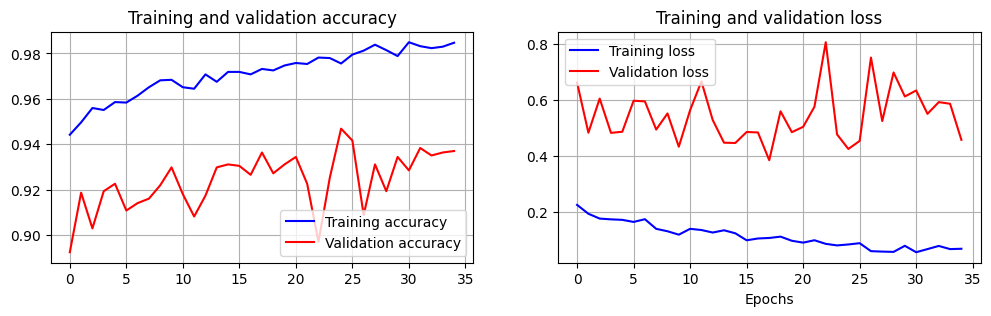

training loss: 0.06977894902229309
validation loss: 0.45755866169929504
training accuracy: 0.9847461581230164
validation accuracy: 0.9370492100715637

epochs: 35

144/144 [==============================] - 54s 374ms/step - loss: 0.0698 - accuracy: 0.9847 - val_loss: 0.4576 - val_accuracy: 0.9370


In [8]:
model.fit(train_data, train_labels,
    epochs=50,
    validation_data=(val_data, val_labels),
    callbacks=callbacks_list)

48/48 [==============================] - 4s 69ms/step


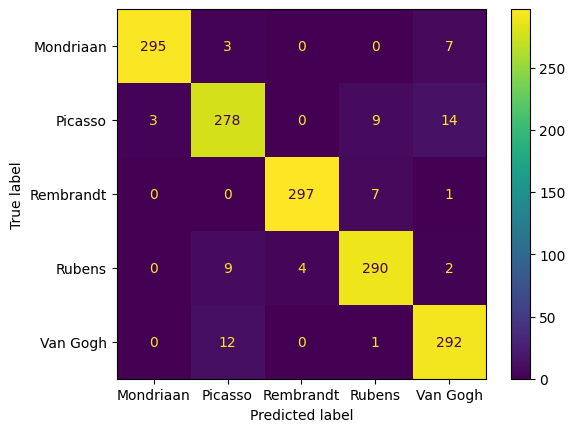

In [10]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_da.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

In [11]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase_da.keras")
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 70ms/step - loss: 0.3611 - accuracy: 0.9528


[0.3611224293708801, 0.9527559280395508]

Na het trainen bekomen we door data augmentation een **accuracy van 95%** en een **loss van 0.36**.
Met data augmentation bekom ik toch nog steeds een **slechter resultaat**.

# Finale model

Als finale model kies ik het model die gebruik maakt van ResNet50 waarbij de laatste 4 lagen van de convbase getrained worden.
Even ter opfrissing, bij dat model bekwam ik een **accuracy van 97%** en een **loss van 0.29**.
Hieronder nog even een screenshot van de training grafiek.

![training graph](training%20graph%204%20trainable%20conv%20base%20layers.JPG)

In [14]:
model = keras.models.load_model("ResNet_data_augmentation_retrainable_convbase.keras")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 42,463,621
Trainable params: 19,930,629
Non-tra